# Solar System Views - Planets and Dwarf Planets

Plot the positions of the major inner and outer solar system planets at a given viewing epoch looking down
on the ecliptic plane (X,Y).  Makes these figures:
 * `SolSys_Inner_<dateTag>.png` - inner solar system with major planets out to past Mars (1.8au radius)
 * `SolSys_Outer_<dateTag>.png` - outer solar system with major planets out to past Neptune (32au radius)
 * `SolSys_Dwarfs_<dateTag>.png` - outer solar system including dwarf planets (100au radius)
 * `SolSys_10au_<dateTag>.png` - Solar system out to Jupiter plus main belt asteroids (10au across)
 * `SolSys_100au_<dateTag>.png` - Solar system out to 100 au across including Asteroids, TNOs, Centaurs, and Dwarfs
 * `SolSys_Halley_<dateTag>.png` - Solar system with comet 1P/Halley, Pluto, and the TNOs
 
The viewing date and appended `dateTag` string are defined in cells below.

Uses `astroquery` to get data from the JPL Horizons databases.

#### See Also

 * `Solar System Asteroids.ipynb` for views of the asteroids (main belt plus Jupiter trojans and dynamical families)
 * `Solar System Dwarfs.ipynb` for views of the dwarf planets (including known-mass candidates)
 * `Solar System TNOs.ipynb` for views of the Trans-Neptunian Objects and Centaurs

In [62]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, LogLocator, NullFormatter

# astropy bits we need

from astropy.time import Time

# used for Newton-Raphson root solving for this plot

from scipy.optimize import newton

# astroquery

from astroquery.mpc import MPC
from astroquery.jplhorizons import Horizons

# suppress nuisance warnings

import warnings
warnings.filterwarnings('ignore',category=UserWarning, append=True)

## Standard Plot Format

#### Aspect Ratio

`aspect` sets the aspect ratio, width/height.  The default aspect ratio is 4:3, 1:1 for square plots, 
and 5:2 (2.5:1) for spectra, and equal aspect ratio for images and plots of Cartesian coordinates.
Use a formula instead of decimal when the result is a fraction (example: `aspect = 4.0/3.0` instead of
`aspect=1.33`).

In [63]:
# Aspect ratio
#
# Exceptions:
#    spectra use full width we use 5:2=2.5 aspect ratio
#
# graphic aspect ratio = width/height

aspect = 1.0 #16.0/9.0

#
# Don't change these unless you really need to (we never have)
#
# fPage is the horizontal fraction of the page occupied by the figure, default 1.0
#
# scaleFac is the LaTeX includegraphics scaling in units of \textwidth, default 1.0
#

fPage = 1.0
scaleFac = 1.0

# Text width in inches - don't change, this is defined by the print layout

textWidth = 6.0 # inches

# Graphic dimensions depending on bitmap or vector format (draft vs production)

figFmt = 'png'
dpi = 600
plotWidth = dpi*fPage*textWidth
plotHeight = plotWidth/aspect
axisFontSize = 10
labelFontSize = 7
lwidth = 0.5
axisPad = 5
wInches = fPage*textWidth # float(plotWidth)/float(dpi)
hInches = wInches/aspect  # float(plotHeight)/float(dpi)

# LaTeX is used throughout for markup of symbols, Times-Roman serif font

plt.rc('text', usetex=True)
plt.rc('font', **{'family':'serif','serif':['Times-Roman'],'weight':'bold','size':'16'})

# Font and line weight defaults for axes

matplotlib.rc('axes',linewidth=lwidth)
matplotlib.rcParams.update({'font.size':axisFontSize})

# axis and label padding

plt.rcParams['xtick.major.pad']=f'{axisPad}'
plt.rcParams['ytick.major.pad']=f'{axisPad}'
plt.rcParams['axes.labelpad'] = f'{axisPad}'

## convenience functions

a_pq(a_p,p,q) = semi-major axis of a p:q resonance for perturber at a_p


In [64]:
def a_pq(a_p,p,q):
    return a_p*(p/q)**(2./3.)

# Plot an unfilled circle of a given radius

def plotCircle(ax,xc,yc,r,color,ltype='-',alpha=0):
    theta = np.linspace(0,2*np.pi,360,endpoint=True)
    xs = xc + r*np.cos(theta)
    ys = yc + r*np.sin(theta)
    ax.plot(xs,ys,linestyle=ltype,color=color,alpha=alpha,lw=0.5)

## Orbit calculation and transform functions

### Eccentric anomaly, $E$

The mean anomaly $M$ is related to the eccentric anomaly $E$ and eccentricity $e$ by Kepler's equation:
 > $M = E - e\sin(E)$

Kepler's equation cannot be solved analytially to compute $E$ given $M$ and $e$ from the orbit elements, so
we solve it numerically using the Newton-Raphson method.  

Define a function $f(E)$
 > $f(E) = E - e\sin(E) - M$

with derivative
 > $\frac{dfE}{dE} = 1 - e\cos(E)$

And solve for $f(E)=0$ given $M$ and $e$.  We will use the `scipy.optimize.newton()` function to solve
for the roots using the Newton-Raphson method.

### True anomaly, $\nu$

Compute the true anomaly $\nu$ given the eccentric anomaly $E$ and orbit eccentricity $e$, using a form that
is numerically safe when E is near $\pm\pi$:
\begin{equation}
  \nu = E + 2\arctan\left(\frac{\beta\sin E}{1-\beta\cos E}\right)
\end{equation}
where
\begin{equation}
  \beta = \frac{e}{1+(1-e^2)^{1/2}}
\end{equation}

### Orbital elements to ecliptic reference plane (x,y,z) coordinates

For a given epoch and osculating orbit elements (a,e,i,n,$\Omega$,$\omega$), `orbXYZ()` computes the
ecliptic reference plane (x,y,z) location of the object at that epoch. It solves Kepler's equation for the
eccentric anomaly $E$ and from that and the true anomaly $\nu$ calculates the location in perifocal (orbital)
plane coordinates (x$_{\rm orb}$,y$_{\rm orb}$).

These are then transformed into ecliptic reference plane XYZ coordinates using the `orbToEclitpic()` function
which performs the Euler matrix transform using the three angles ($\Omega$,$i$,$\omega$).

### Convenience Functions

`traceOrb()` traces a complete orbit in (XYZ) ecliptic coordinates given Keplerian osculating orbit elements
(a,e,i,$Omega$,$omega$).

`corotXY()` rotates ecliptic plane (x,y) coordiate into the the co-rotating reference frame of a planet 
with ecliptic plane coordinates (xP,yP).

In [65]:
# Kepler's equation - assumes M and E in radians

def kepler(E,M,e):
    return (E - e*np.sin(E) - M)

# Derivative of Kepler's equation, E in radians

def kepler_deriv(E,M,e):
    return (1.0 - e*np.cos(E))

# Compute the eccentric anomaly - M must be in radians

def eccAnomaly(M,e):
    E = newton(kepler, M, kepler_deriv, args=(M,e))
    return E

# Compute the true anomaly - E must be in radians

def trueAnomaly(E,e):
    beta = e/(1.0+np.sqrt(1-e*e))
    sin_nu = beta*np.sin(E)
    cos_nu = 1 - beta*np.cos(E)
    nu = E + 2.0*np.arctan2(sin_nu,cos_nu)
    return nu

# Convert orbital plane (x,y) to ecliptic plane (x,y,z)
    
def orbToEcliptic(xorb,yorb,Omega,i,omega):

    # Euler matrix - angles must be in radians
    
    m_xx = np.cos(omega)*np.cos(Omega) - np.sin(omega)*np.cos(i)*np.sin(Omega)
    m_xy = np.cos(omega)*np.sin(Omega) + np.sin(omega)*np.cos(i)*np.cos(Omega)
    m_xz = np.sin(omega)*np.sin(i)
    
    m_yx = -np.sin(omega)*np.cos(Omega) - np.cos(omega)*np.cos(i)*np.sin(Omega)
    m_yy = -np.sin(omega)*np.sin(Omega) + np.cos(omega)*np.cos(i)*np.cos(Omega)
    m_yz =  np.cos(omega)*np.sin(i)
    
    # because zorb=0 by definition, we don't need these
    #m_zx =  np.sin(i)*np.sin(Omega)
    #m_zy = -np.sin(i)*np.cos(Omega)
    #m_zz =  np.cos(i)
    
    # compute ecliptic XYZ
    
    xEcl = xorb*m_xx + yorb*m_yx # + zorb*m_zx
    yEcl = xorb*m_xy + yorb*m_yy # + zorb*m_zy
    zEcl = xorb*m_xz + yorb*m_yz # + zorb*m_zz
    
    return xEcl,yEcl,zEcl

# Compute ecliptic (x,y,z) coordinates at epochXY given orbit elements (a,e,n,M) at epoch elEpoch

def orbXYZ(a,e,n,M,i,Omega,omega,elEpoch,epochXY):
    dT = epochXY - elEpoch # years
    dM = np.radians(dT*n*365.25) # radians
    Mep = M + dM # mean anomaly at epochXY in radians
    
    # eccentric anomaly, E, at epochXY in radians
    
    E = eccAnomaly(Mep,e)
    
    # true anomaly, nu, at epochXY in radians
    
    nu = trueAnomaly(E,e)
    
    # heliocentric radius in au
    
    r = a*(1-e*e)/(1 + e*np.cos(nu))
    
    # orbit plane (x,y), perihelion is toward +x
    
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,omega)

    return x,y,z

# trace a full orbit in ecliptic cartesian coordinats

def traceOrb(a,e,i,Omega,peri):
    nu = np.linspace(0.0,2.*np.pi,501)
    r = a*(1-e*e)/(1+e*np.cos(nu))
    xorb = r*np.cos(nu)
    yorb = r*np.sin(nu)
    
    x,y,z = orbToEcliptic(xorb,yorb,Omega,i,peri)

    return x,y,z

# rotate ecliptic (x,y) coordinates into the co-rotating heliocentric frame of planet at (xP,yP)

def corotXY(x,y,xP,yP):
    dX = x - xP
    dY = y - yP

    rP = np.sqrt(xP*xP + yP*yP) # heliocentric distance
    theta = np.arctan2(yP,xP)   # rotation angle

    xcr =  dX*np.cos(theta) + dY*np.sin(theta) + rP
    ycr = -dX*np.sin(theta) + dY*np.cos(theta)

    return xcr,ycr

## Setup

### View Epoch

`viewDate` defines the date for viewing the solar system.  Dates need to be in ISO8601 format with time, 
`CCYY-MM-DDThh:mm:ss` in UTC time system, for example: 
 > `2025-02-02T00:00:00`
 
is midnight UTC time on 2025 February 2.

### Date Tag

`dateTag` is an identifier added to the output PNG filenames, usually with the date.  Should be kept simple
with no spaces, for example:
 > `20250202`

corresponds to the date above. It is appended to the main filename like `InnerSolSys_20250202.png`.

You can define `dateTag` to be any non-date string to use as a unique identifier for your plots.

In [66]:
# epoch for the view

viewDate = "2025-03-28T00:00:00" # UTC
dateTag = "20250328"

## Major planet orbit elements

Data from the JPL Horizons database retrieved using `astroquery`

In [67]:
# epoch conversions for the orbit calculations

t = Time(viewDate,format='isot',scale='tt')
viewEpoch = t.decimalyear
viewJD = t.jd

# Planets, including inner/outer division and dwarf planets.  Names are for the JPL Horizons query which requires specificity
# so we carry a uniqueID dictionary that takes care of that specificity

planets = ["Mercury","Venus","Earth","Mars","Jupiter","Saturn","Uranus","Neptune","Ceres",
           "Pluto","Eris","Ceres","Haumea","Makemake","Orcus","Gonggong","Quaoar"]

inner = ["Mercury","Venus","Earth","Mars"]
outer = ["Jupiter","Saturn","Uranus","Neptune"]
dwarfs = ["Ceres","Pluto","Eris","Makemake","Haumea","Orcus","Gonggong","Quaoar"]
comets = ["1P/Halley","67P/Churyumov-Gerasimenko","9P/Tempel 1","21P/Giacobini-Zinner","26P/Grigg-Skjellerup",
          "19P/Borrelly","81P/Wild 2","C/Hale-Bopp","C/Hyakutake"]

# JPL Horizons unique identifiers for each body

uniqueID = {"Mercury":"Mercury Barycenter",
            "Venus":"Venus Barycenter",
            "Earth":"Earth-Moon Barycenter",
            "Mars":"Mars Barycenter",
            "Jupiter":"Jupiter Barycenter",
            "Saturn":"Saturn Barycenter",
            "Uranus":"Uranus Barycenter",
            "Neptune":"Neptune Barycenter",
            "Pluto":"Pluto Barycenter",
            "Ceres":"Ceres",
            "Pluto":"9",
            "Eris":"20136199",
            "Haumea":"20136108",
            "Makemake":"Makemake",
            "Gonggong":"Gonggong",
            "Orcus":"20090482",
            "Quaoar":"20050000",
            "1P/Halley":"90000030",
            "9P/Tempel 1":"90000192",
            "C/Hale-Bopp":"Hale-Bopp",
            "67P/Churyumov-Gerasimenko":"90000703",
            "21P/Giacobini-Zinner":"90000324",
            "26P/Grigg-Skjellerup":"90000377",
            "19P/Borrelly":"90000305",
            "81P/Wild 2":"90000863",
            "C/Hyakutake":"90002231"
           }

# colors for the bodies

colors = {"Mercury":"#e7e8ec",
          "Venus":"#f9c21a",
          "Earth":"#6b93d6",
          "Mars":"#c1440e",
          "Jupiter":"#c99039",
          "Saturn":"#d8ca9d",
          "Uranus":"#d1e7e7",
          "Neptune":"#85addb",
          "Ceres":"cyan",
          "Pluto":"#fff1d5",
          "Eris":"yellow",
          "Haumea":"orange",
          "Makemake":"red",
          "Gonggong":"green",
          "Orcus":"gold",
          "Quaoar":"#bb0000",
          "1P/Halley":"#bb0000",
          "9P/Tempel 1":"green",
          "C/Hale-Bopp":"cyan",
          "67P/Churyumov-Gerasimenko":"gold",
          "21P/Giacobini-Zinner":"magenta",
          "26P/Grigg-Skjellerup":"#85addb",
          "19P/Borrelly":"white",
          "81P/Wild 2":"gray",
          "C/Hyakutake":"#add8e6"}

# JPL Horizons database query for the viewing epoch.

xOrb = {}
yOrb = {}
zOrb = {}
xP = {}
yP = {}
zP = {}
for planet in planets:
    obj = Horizons(id=f"{uniqueID[planet]}",epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    # Planet osculating orbit XYZ ecliptic coordinates trace
    
    xOrb[planet],yOrb[planet],zOrb[planet] = traceOrb(aP,eP,iP,OmP,wP)
    
    # Planet instantaneous XYZ ecliptic coordinates
    
    xP[planet],yP[planet],zP[planet] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)

for body in comets:
    obj = Horizons(id=f"{uniqueID[body]}",epochs=viewJD)
    el = obj.elements()
    aP = el['a'].value[0]
    eP = el['e'].value[0]
    iP = np.radians(el['incl'].value[0])
    MP = np.radians(el['M'].value[0])
    OmP = np.radians(el['Omega'].value[0])
    wP = np.radians(el['w'].value[0])
    nP = el['n'].value[0]
    
    # Comet osculating orbit XYZ ecliptic coordinates trace
    
    xOrb[body],yOrb[body],zOrb[body] = traceOrb(aP,eP,iP,OmP,wP)
    
    # Comet instantaneous XYZ ecliptic coordinates
    
    xP[body],yP[body],zP[body] = orbXYZ(aP,eP,nP,MP,iP,OmP,wP,viewEpoch,viewEpoch)


## Make the Plots

### Inner Solar System

Show the inner solar system out to Mars but not to the asteroids


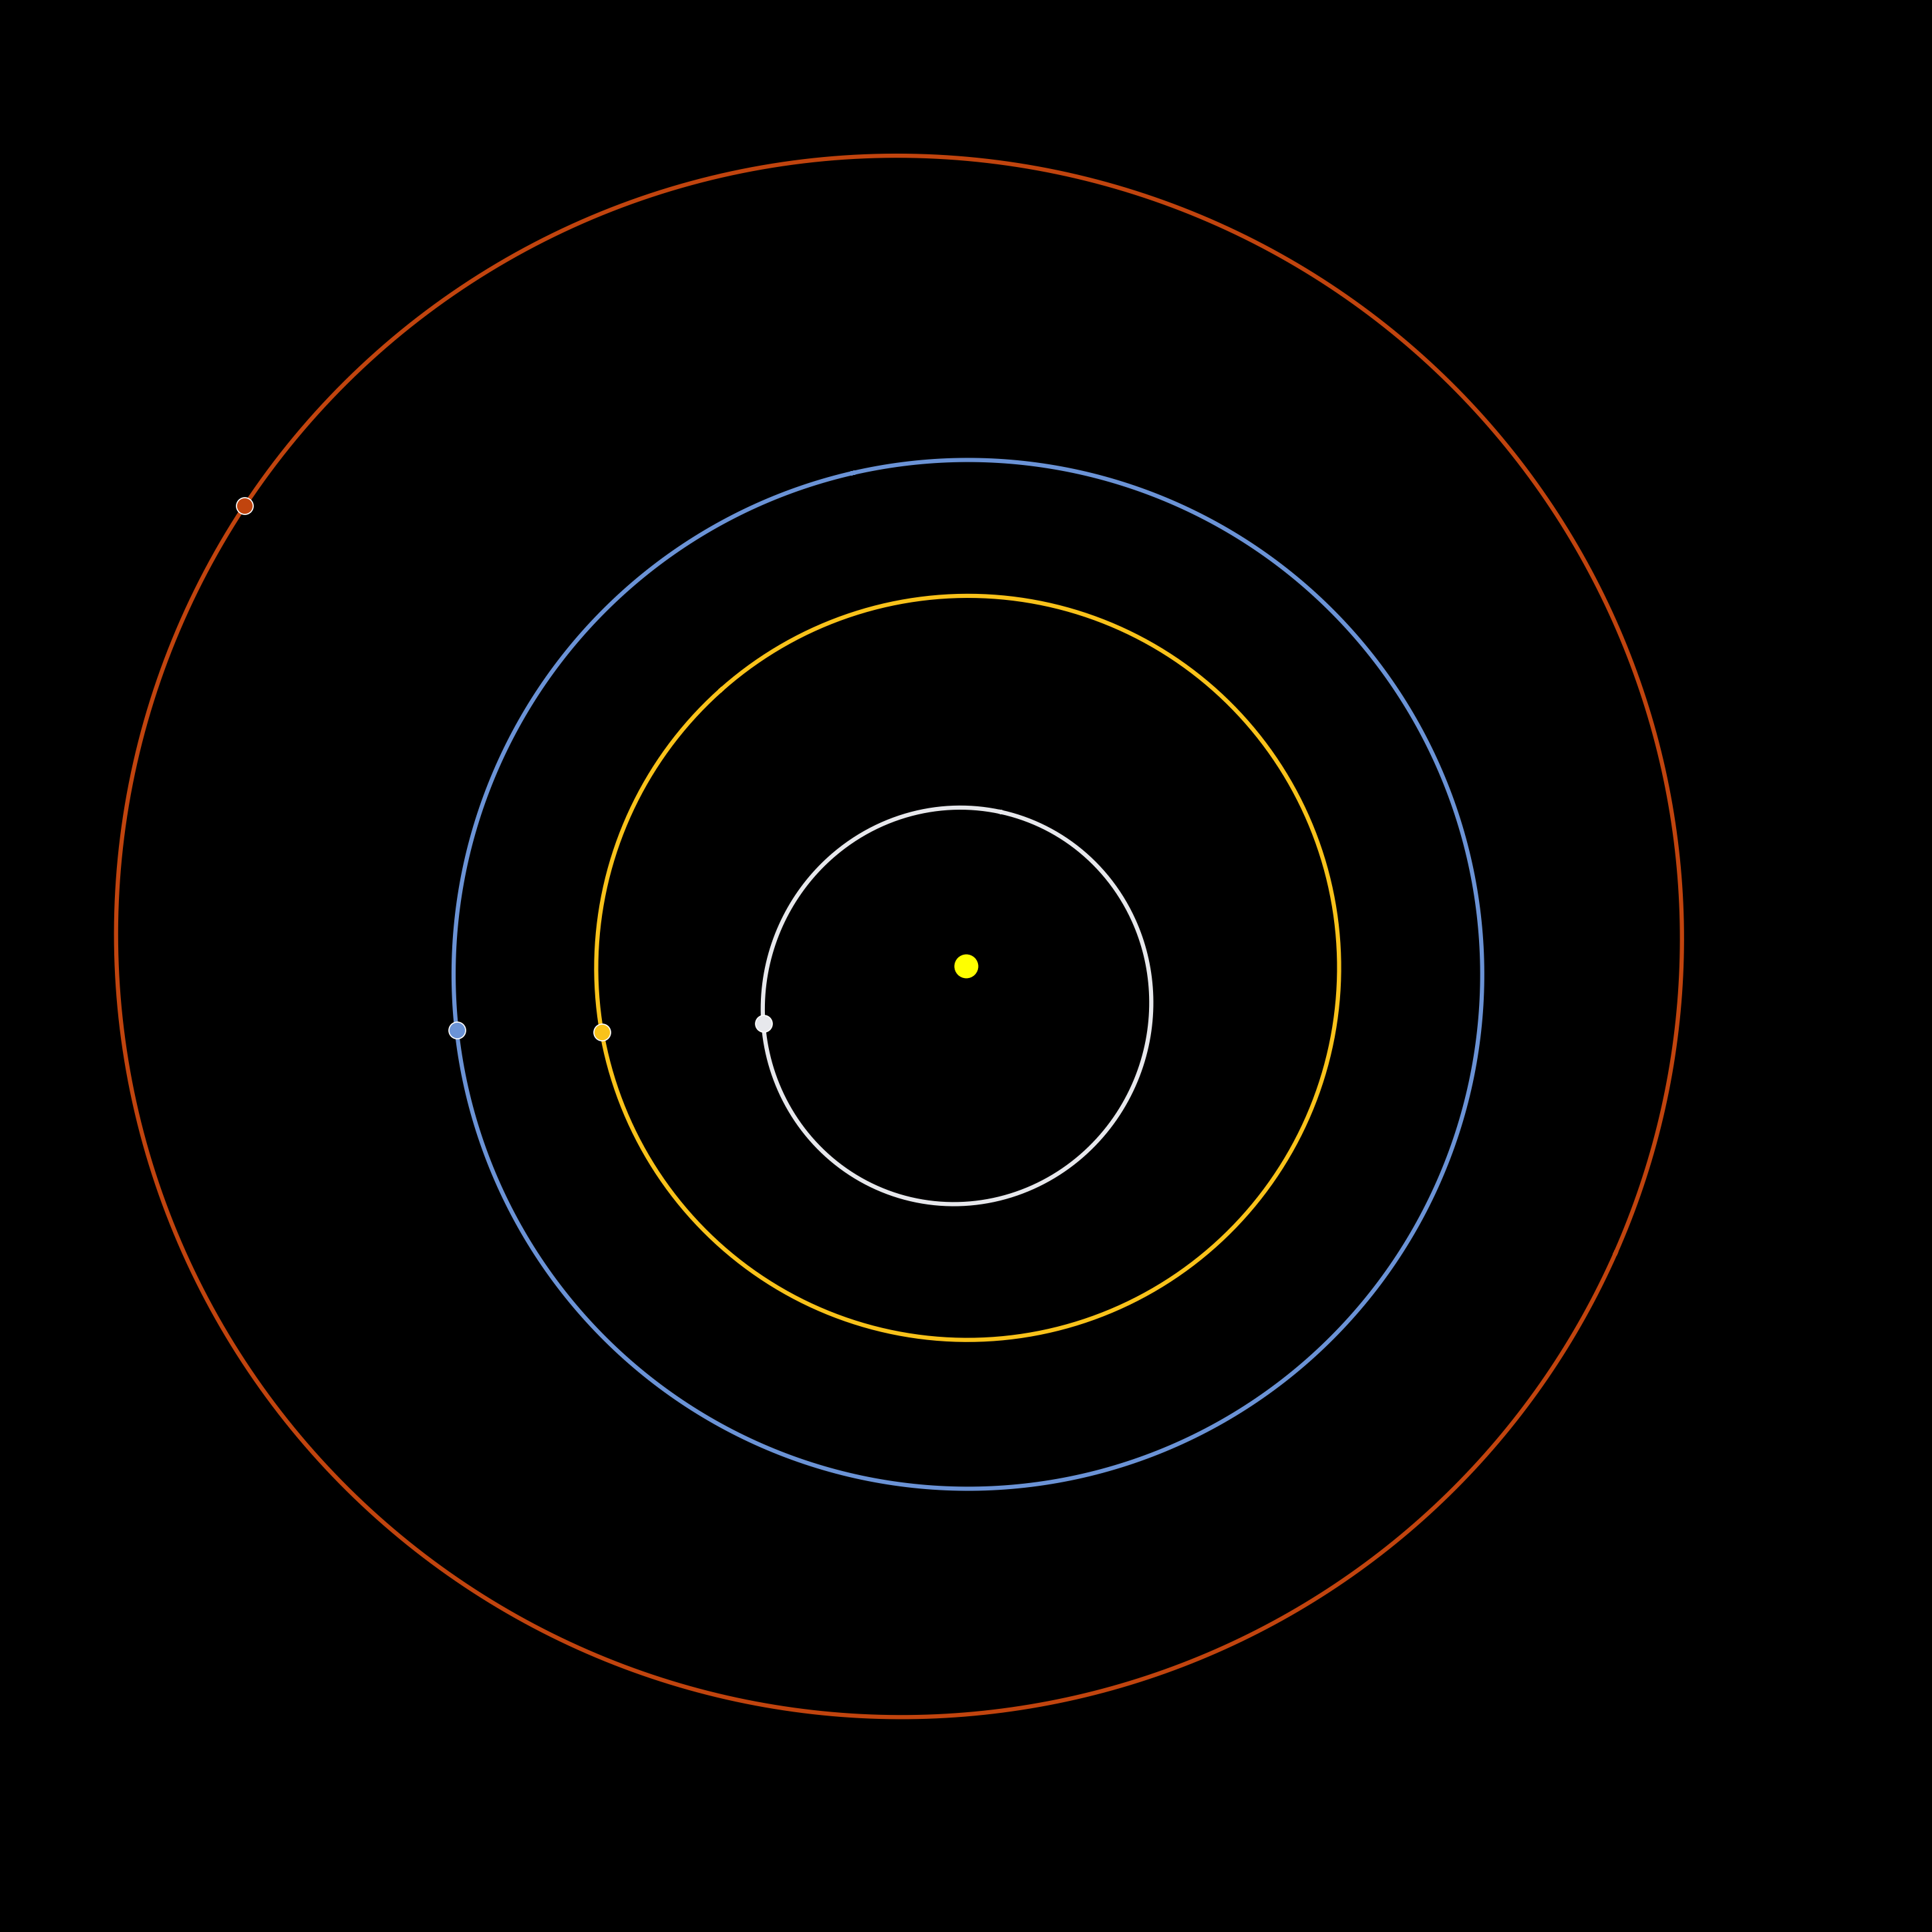

In [68]:
plotFile = f"SolSys_Inner_{dateTag}.png"
aMax = 1.8

# plot has dark background, 1:1 aspect

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# Planet orbits

for planet in inner:
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=0.75,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=3,mfc=colors[planet],mec="white",mew=0.2,alpha=1,zorder=10)
    
# and the sun

ax.plot(0,0,'o',ms=4,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

### Outer Solar System

Show the inner and outer solar system out to 32au

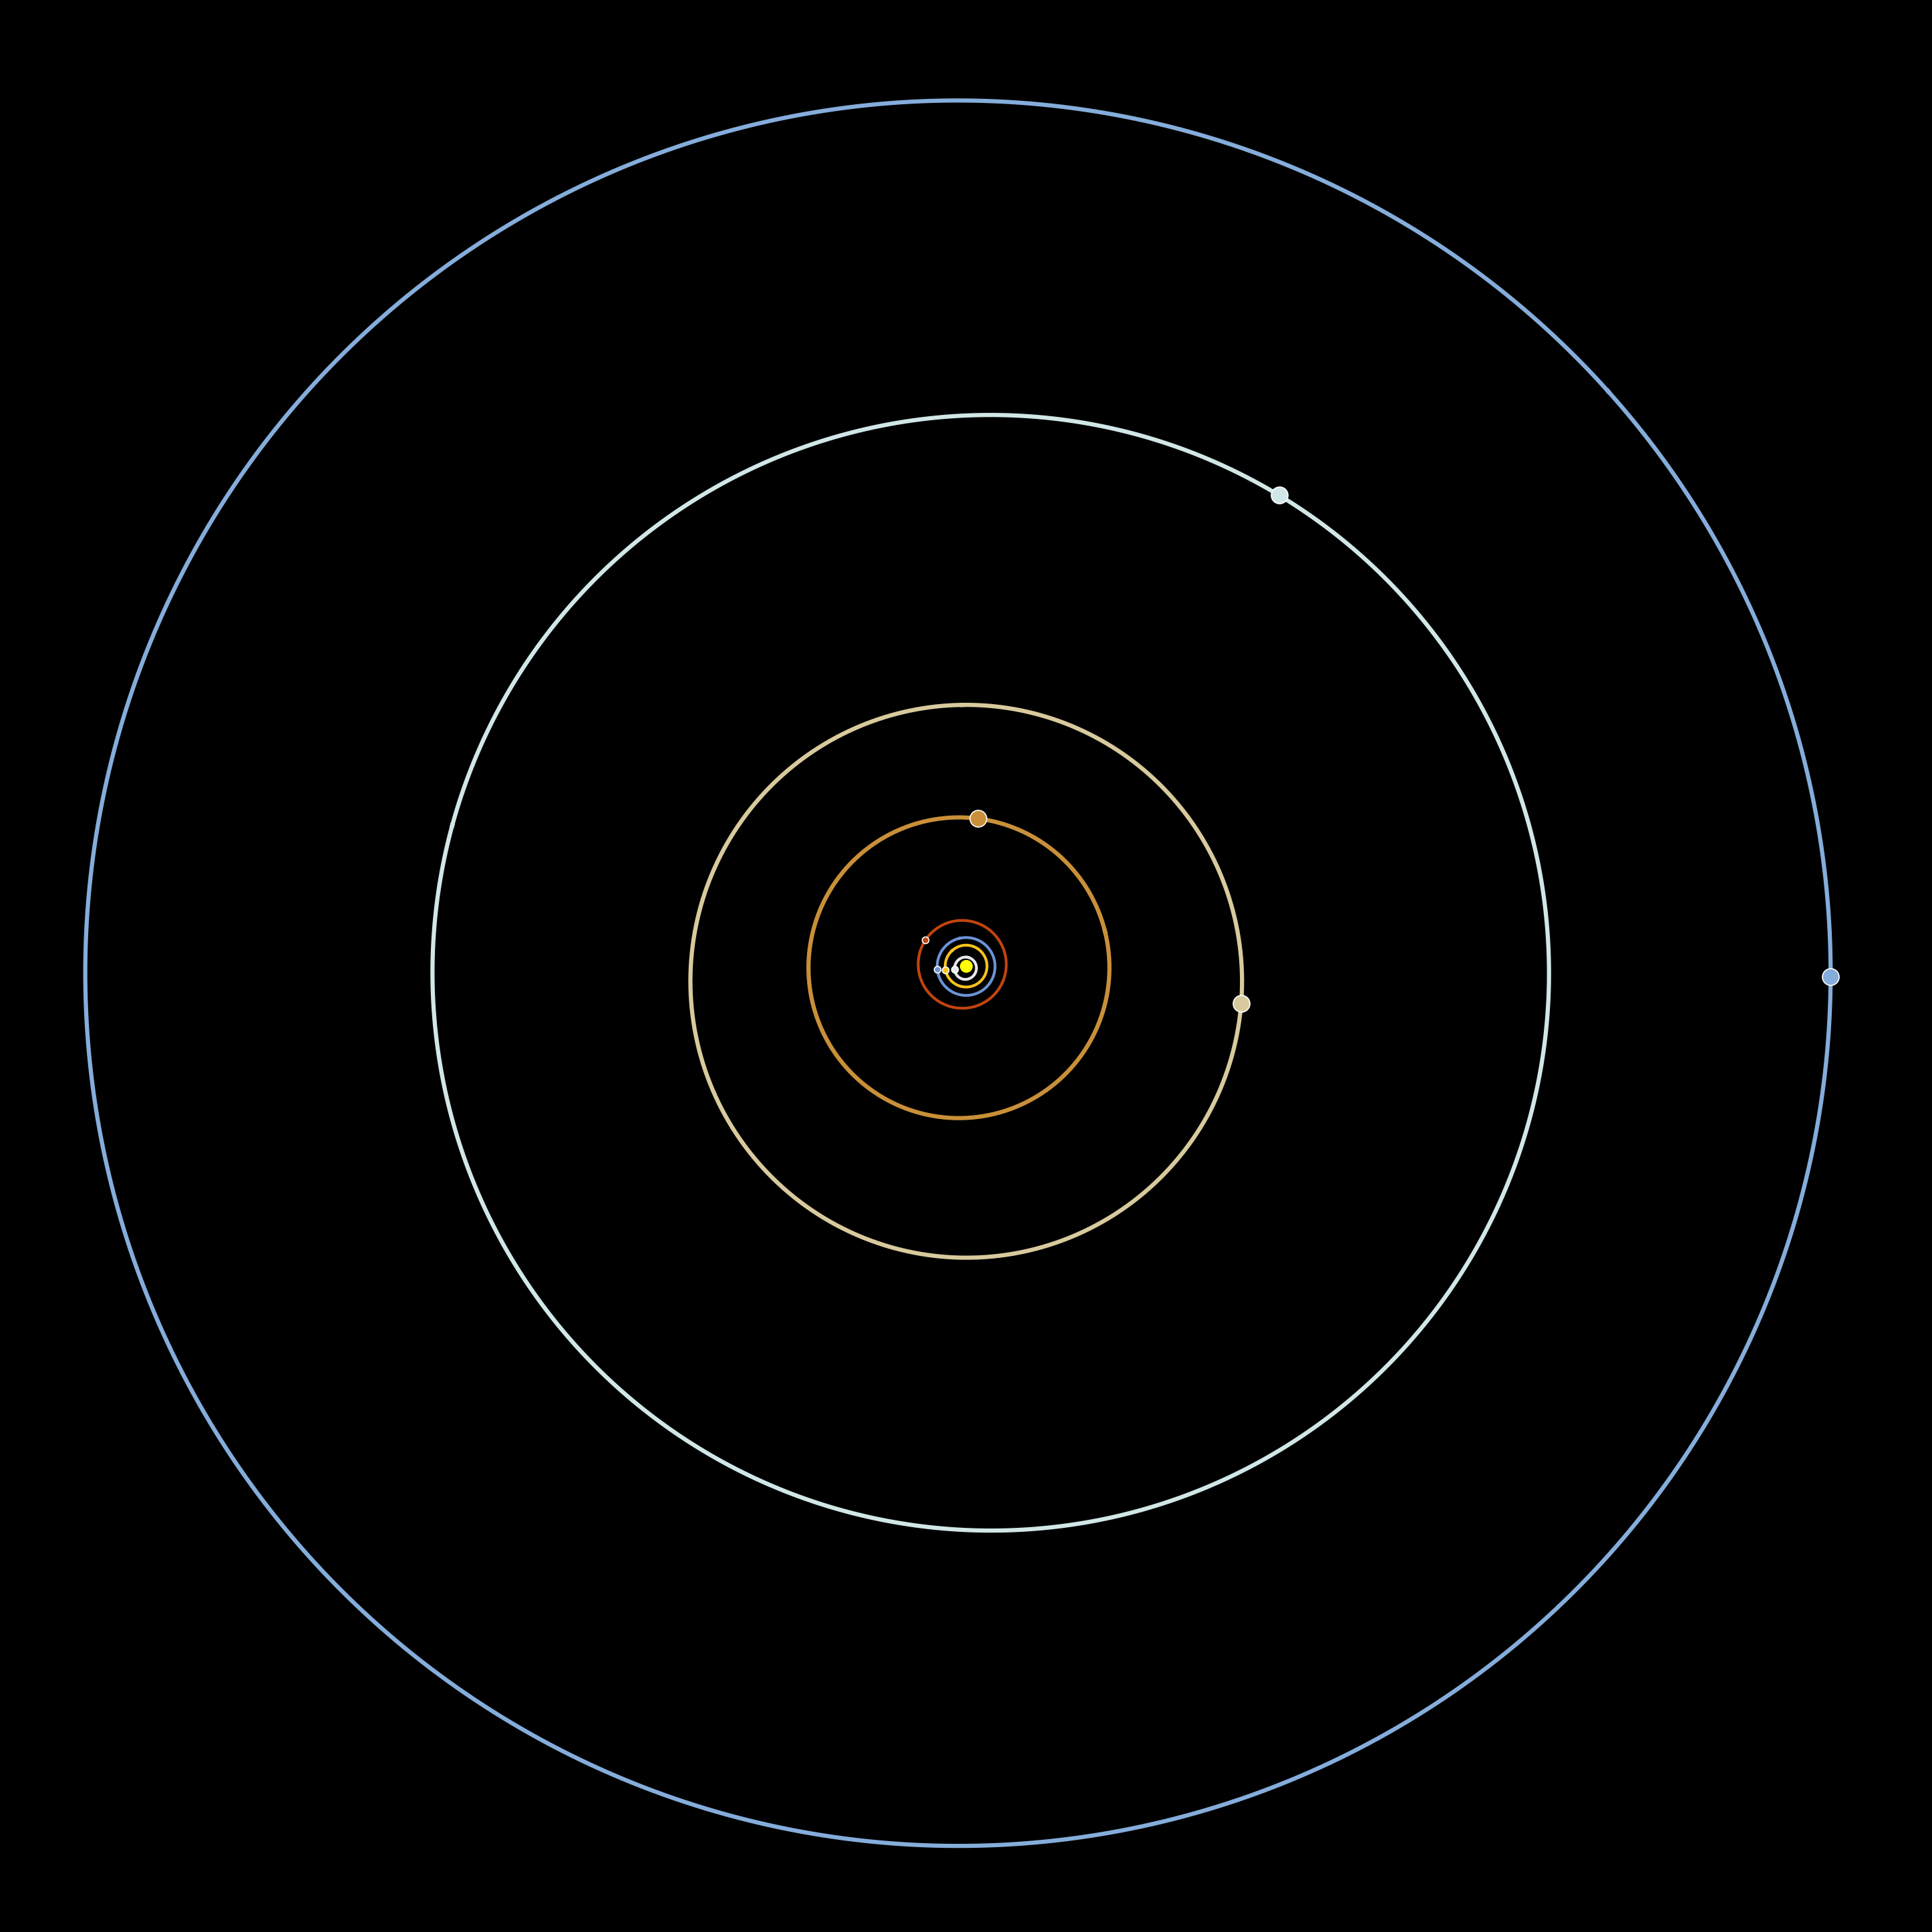

In [69]:
plotFile = f"SolSys_Outer_{dateTag}.png"

aMax = 32.0
    
# plot has dark background, 1:1 aspect

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# Planet orbits

for planet in inner:
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=0.5,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=1.2,mfc=colors[planet],mec="white",mew=0.2,alpha=1,zorder=10)

for planet in outer:
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=0.75,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=3,mfc=colors[planet],mec="white",mew=0.2,alpha=1,zorder=10)

# and the sun

ax.plot(0,0,'o',ms=2,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

### Solar System and Dwarf Planets

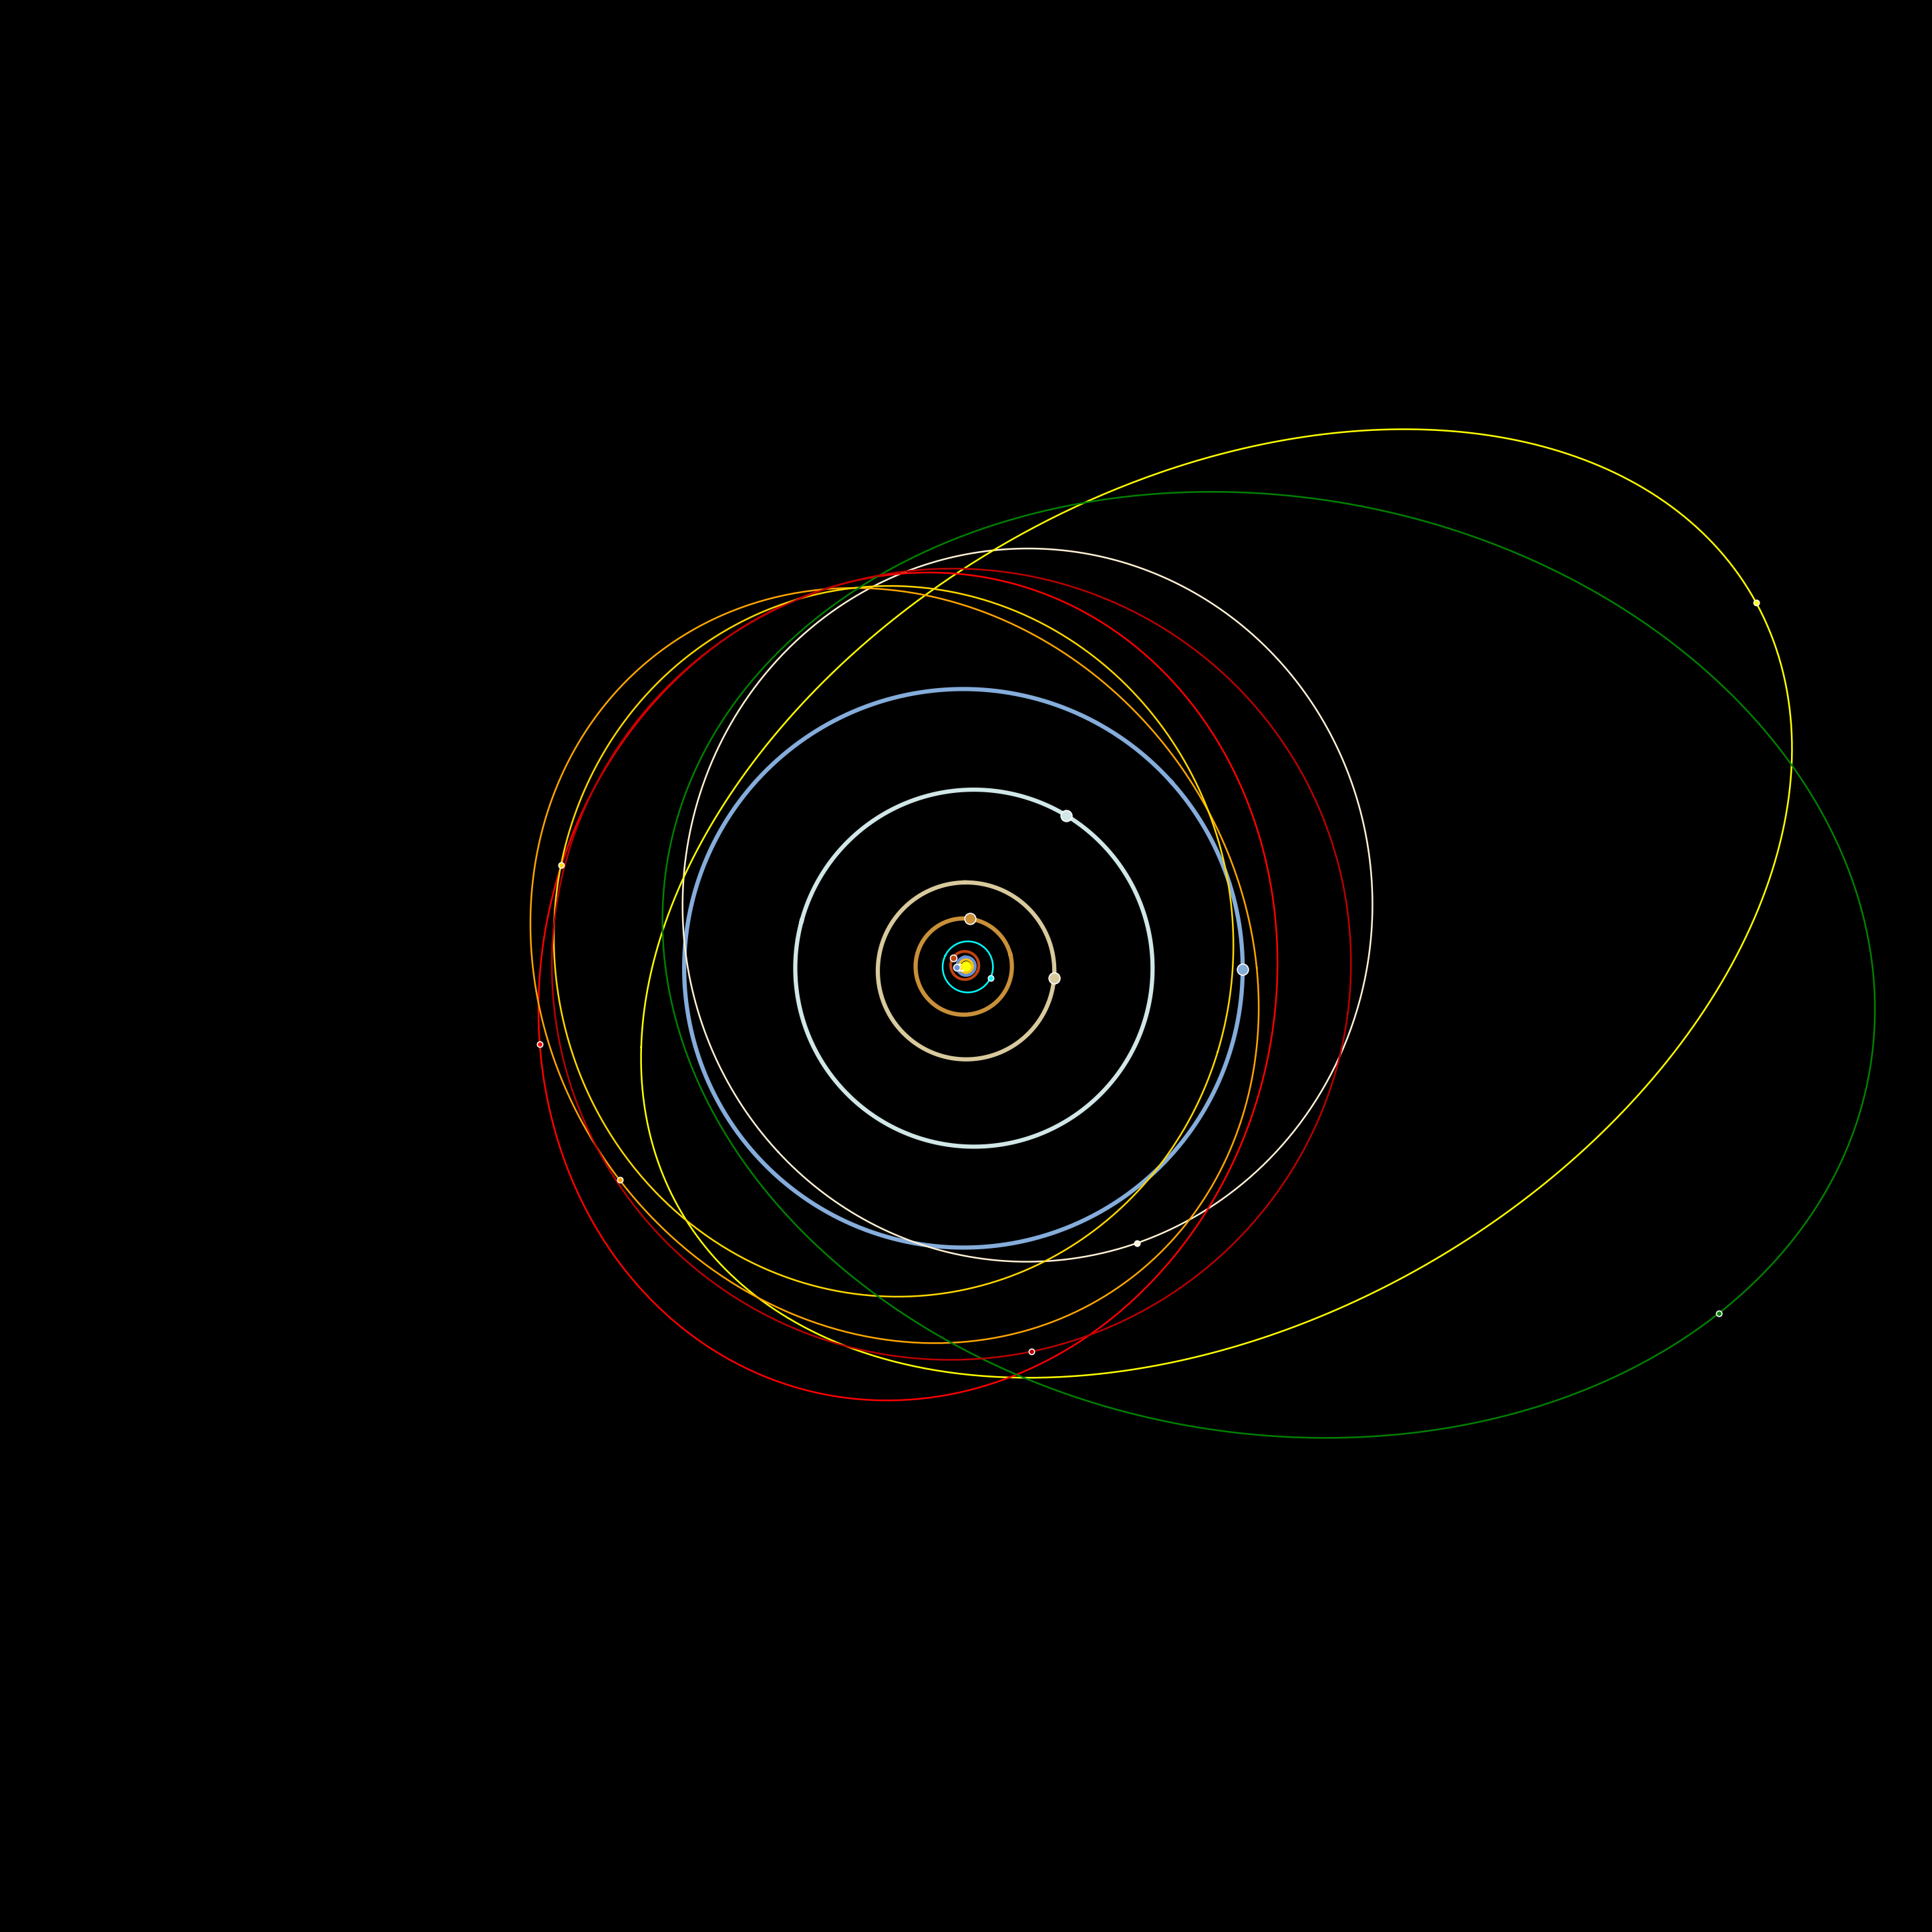

In [70]:
plotFile = f"SolSys_Dwarfs_{dateTag}.png"
aMax = 100.0
    
# plot has dark background, 1:1 aspect

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# Planet orbits

for planet in inner:
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=0.5,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=1.2,mfc=colors[planet],mec="white",mew=0.2,alpha=1,zorder=10)

for planet in outer:
    ax.plot(xOrb[planet],yOrb[planet],'-',lw=0.75,color=colors[planet],zorder=9)
    ax.plot(xP[planet],yP[planet],'o',ms=2,mfc=colors[planet],mec="white",mew=0.2,alpha=1,zorder=10)

for body in dwarfs:
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.3,color=colors[body],zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=1,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)

# and the sun

ax.plot(0,0,'o',ms=1.5,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

## Asteroids and TNOs

These plots add the main belt asteroids and TNOs and Centaurs at various zoom-out limits.

### Main Belt

Retrieve ~16k bright main-belt asteroids from the MPC.  Max download from the MPC with `astroquery` is 16384 objects.  Setting
$H=14$mag makes sure the first 16384 objects are all bright.


In [71]:
# constraints

Hmax = 14.0 # maximum absolute magnitude 

# Main Belt

result = MPC.query_objects('asteroid',
                           orbit_type=0,absolute_magnitude_max=Hmax,
                           return_fields='semimajor_axis,eccentricity,inclination,argument_of_perihelion,ascending_node,epoch_jd,mean_anomaly,mean_daily_motion,absolute_magnitude,orbit_type')

a = np.array([float(d.get('semimajor_axis',None)) for d in result])
e = np.array([float(d.get('eccentricity',None)) for d in result])
n = np.array([float(d.get('mean_daily_motion',None)) for d in result])
i = np.radians(np.array([float(d.get('inclination',None)) for d in result]))
peri = np.radians(np.array([float(d.get('argument_of_perihelion',None)) for d in result]))
Omega = np.radians(np.array([float(d.get('ascending_node',None)) for d in result]))
M = np.radians(np.array([float(d.get('mean_anomaly',None)) for d in result]))
epJD = np.array([d.get('epoch_jd',None) for d in result])

t = Time(epJD,format='jd',scale='tt')
elEpoch = t.decimalyear

xMB,yMB,zMB = orbXYZ(a,e,n,M,i,Omega,peri,elEpoch,viewEpoch)

print(f"{len(a)} Main Belt asteroids H<{Hmax:.1f}mag")

16384 Main Belt asteroids H<14.0mag


### TNOs and Centaurs

We select TNOs and Centaurs using the following criteria:
 * `orbit_type=10` selects "distant objects"
 * `perihelion_distance_min=5.2` for Centaurs which usually have perihelia no closer than Jupiter (5.2au)
 * `semimajor_axis_min=20` 20au semi-major axis to clean up stray comets
 
This retrieves >5000 objects. While the selection is not perfect it is good enough for illustration 
purposes.  The MPC's TNO and Centaur table is better vetted, but not accessible with `astroquery`.

In [72]:
result = MPC.query_objects('asteroid',
                           semimajor_axis_min=20.0,
                           perihelion_distance_min=5.2,
                           orbit_type=10,
                           return_fields='semimajor_axis,eccentricity,inclination,argument_of_perihelion,ascending_node,epoch_jd,mean_anomaly,mean_daily_motion,orbit_type')

a = np.array([float(d.get('semimajor_axis',None)) for d in result])
e = np.array([float(d.get('eccentricity',None)) for d in result])
n = np.array([float(d.get('mean_daily_motion',None)) for d in result])
i = np.radians(np.array([float(d.get('inclination',None)) for d in result]))
peri = np.radians(np.array([float(d.get('argument_of_perihelion',None)) for d in result]))
Omega = np.radians(np.array([float(d.get('ascending_node',None)) for d in result]))
M = np.radians(np.array([float(d.get('mean_anomaly',None)) for d in result]))
epJD = np.array([d.get('epoch_jd',None) for d in result])

t = Time(epJD,format='jd',scale='tt')
elEpoch = t.decimalyear

xTNO,yTNO,zTNO = orbXYZ(a,e,n,M,i,Omega,peri,elEpoch,viewEpoch)

print(f'Number of TNOs and Centaurs: {len(a)}')

Number of TNOs and Centaurs: 5343


## Solar System out to ~10au across

Plot the solar system looking "down" on the XY ecliptic plane out to the orbit of Saturn, remove color coding
on the asteroids and only showing main belt at full brightness, muting the other groups.

See the `Solar System Asteroids.ipynb` notebook for more asteroid options.

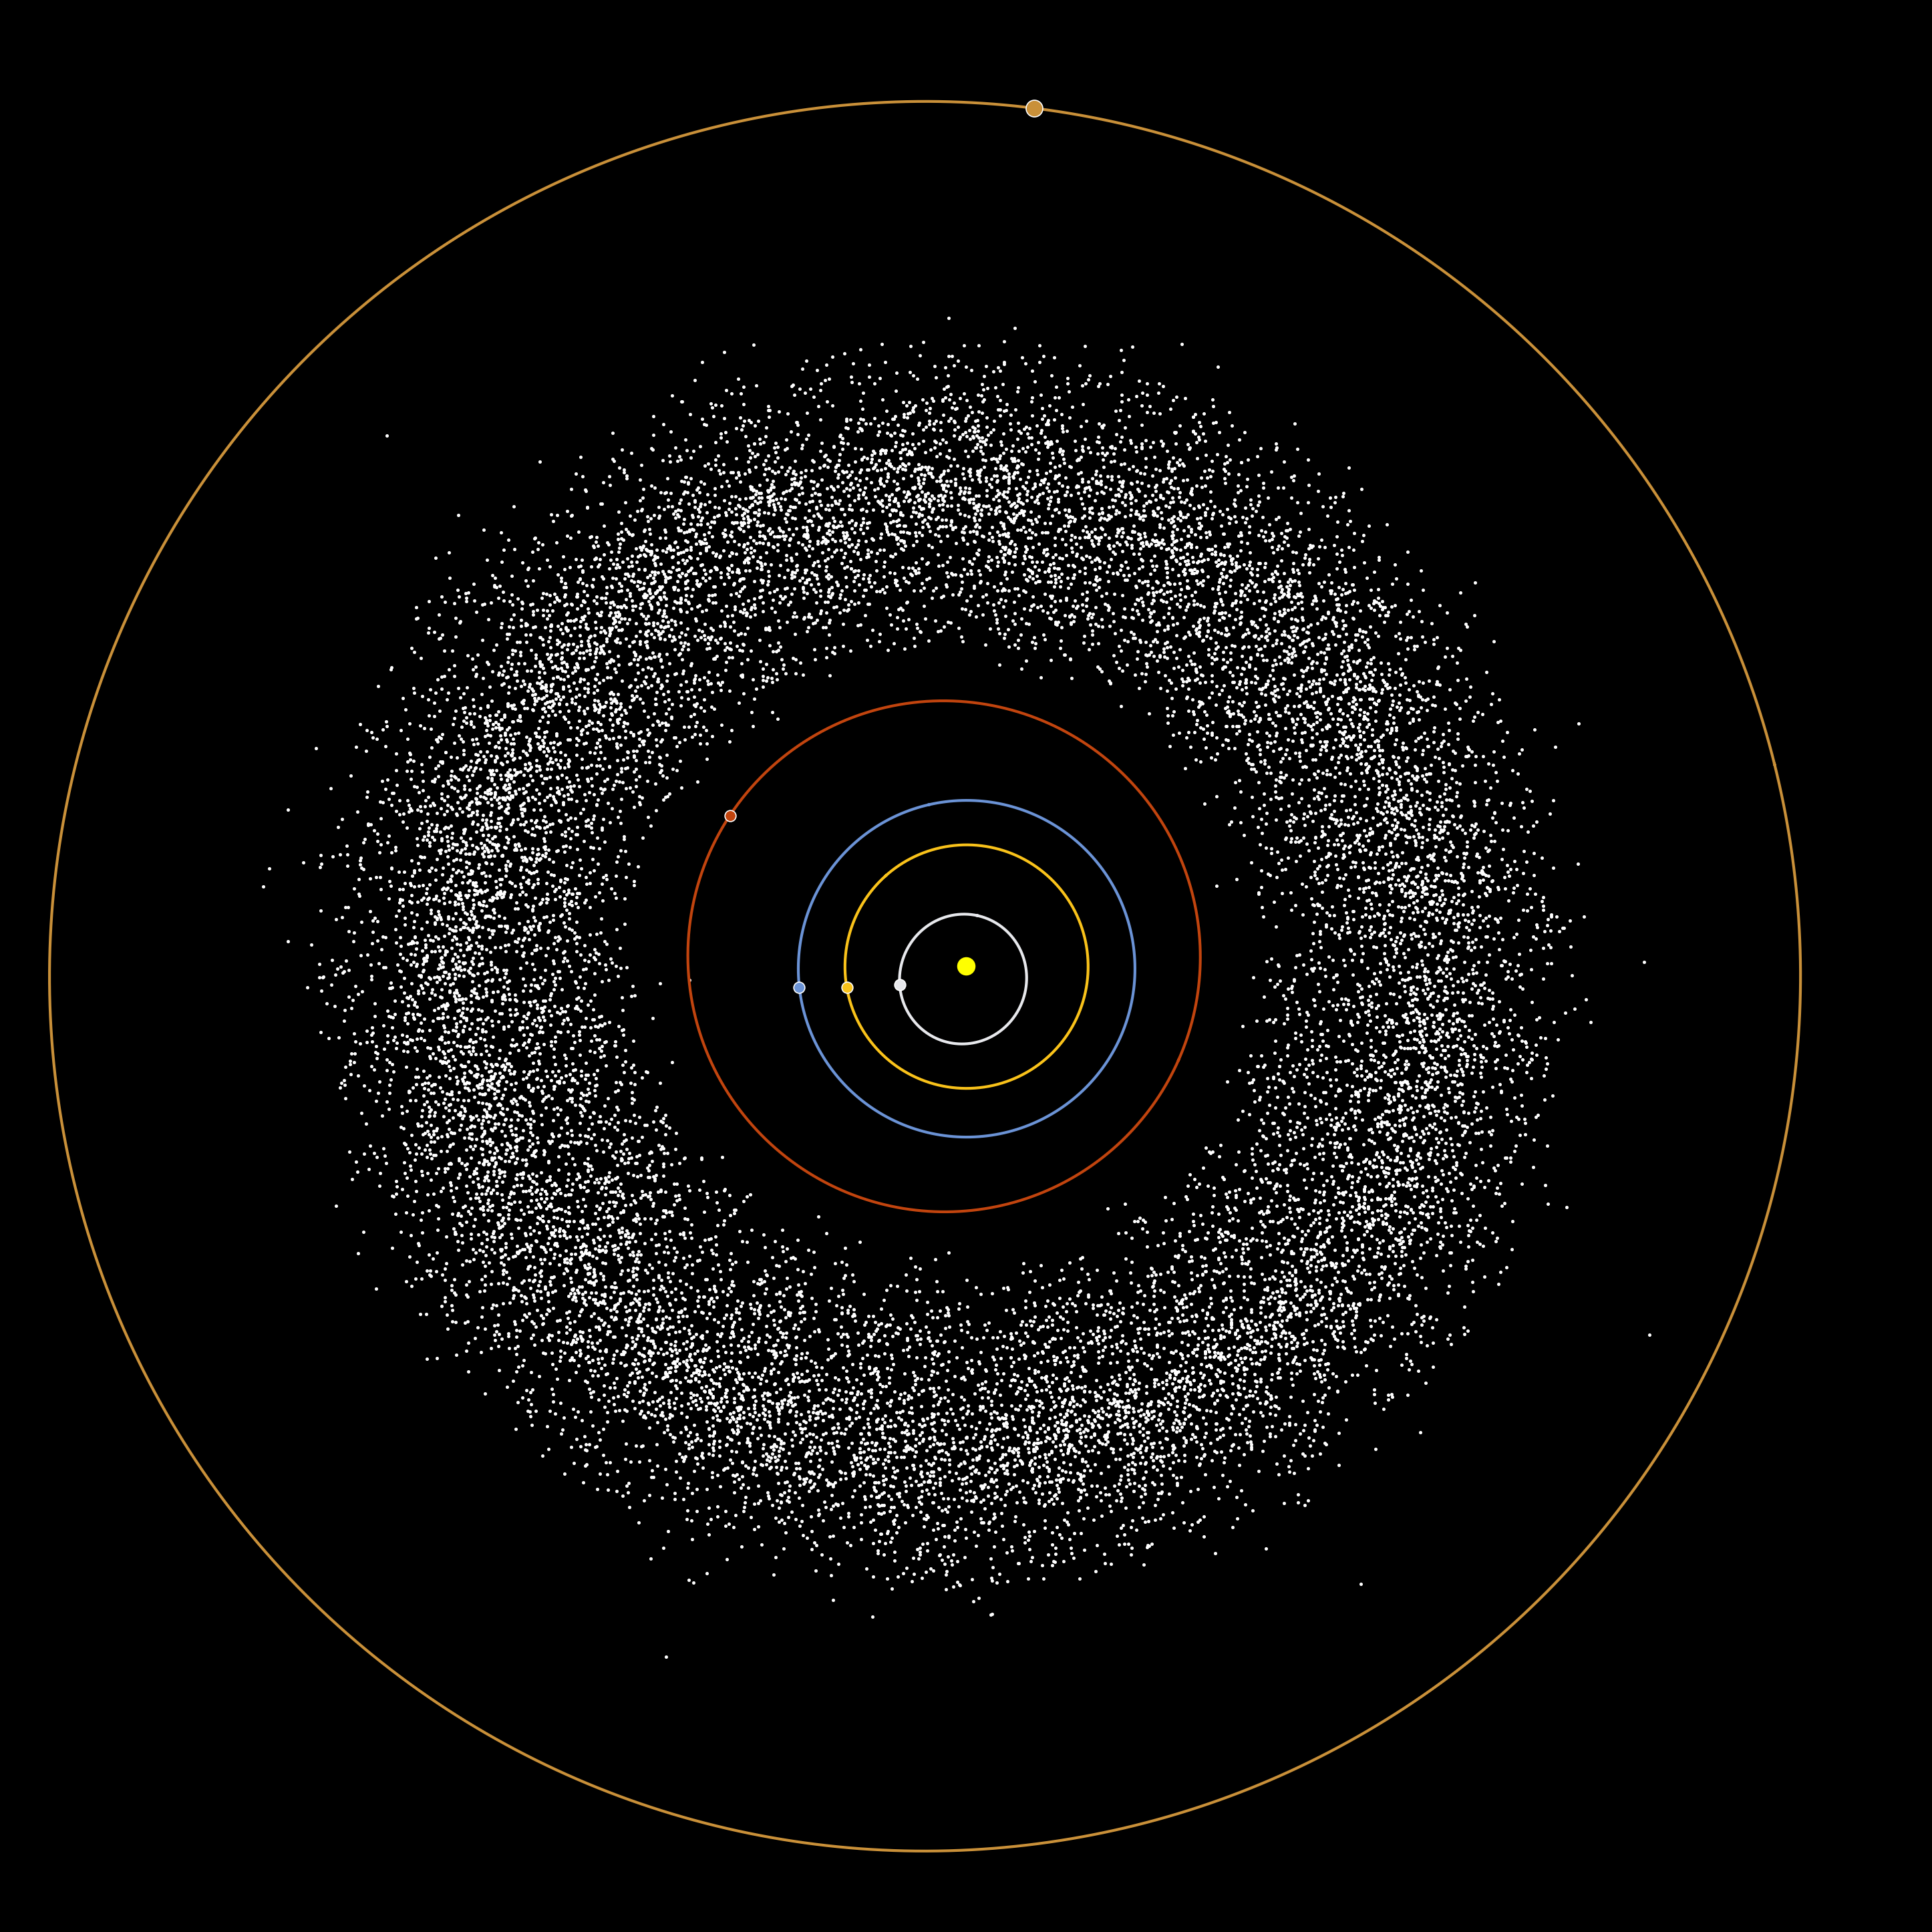

In [73]:
plotFile = f"SolSys_10au_{dateTag}.png"
aMax = 5.5

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# plot the Asteroids

ax.plot(xMB,yMB,'o',ms=0.5,mfc='white',mec='white',mew=0.1,alpha=1,zorder=8)

# Planet orbits

for body in ['Mercury','Venus','Earth','Mars','Jupiter']:
    if body == 'Jupiter':
        pms = 3
    else:
        pms = 2
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)
    
# and the sun

ax.plot(0,0,'o',ms=3,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

## Solar System out to ~100au

Plot the solar system looking "down" on the XY ecliptic plane beyond the orbit of Neptune, including the 
main belt and TNOs and Centaurs plus dwarf planets (including candidates with known mass).

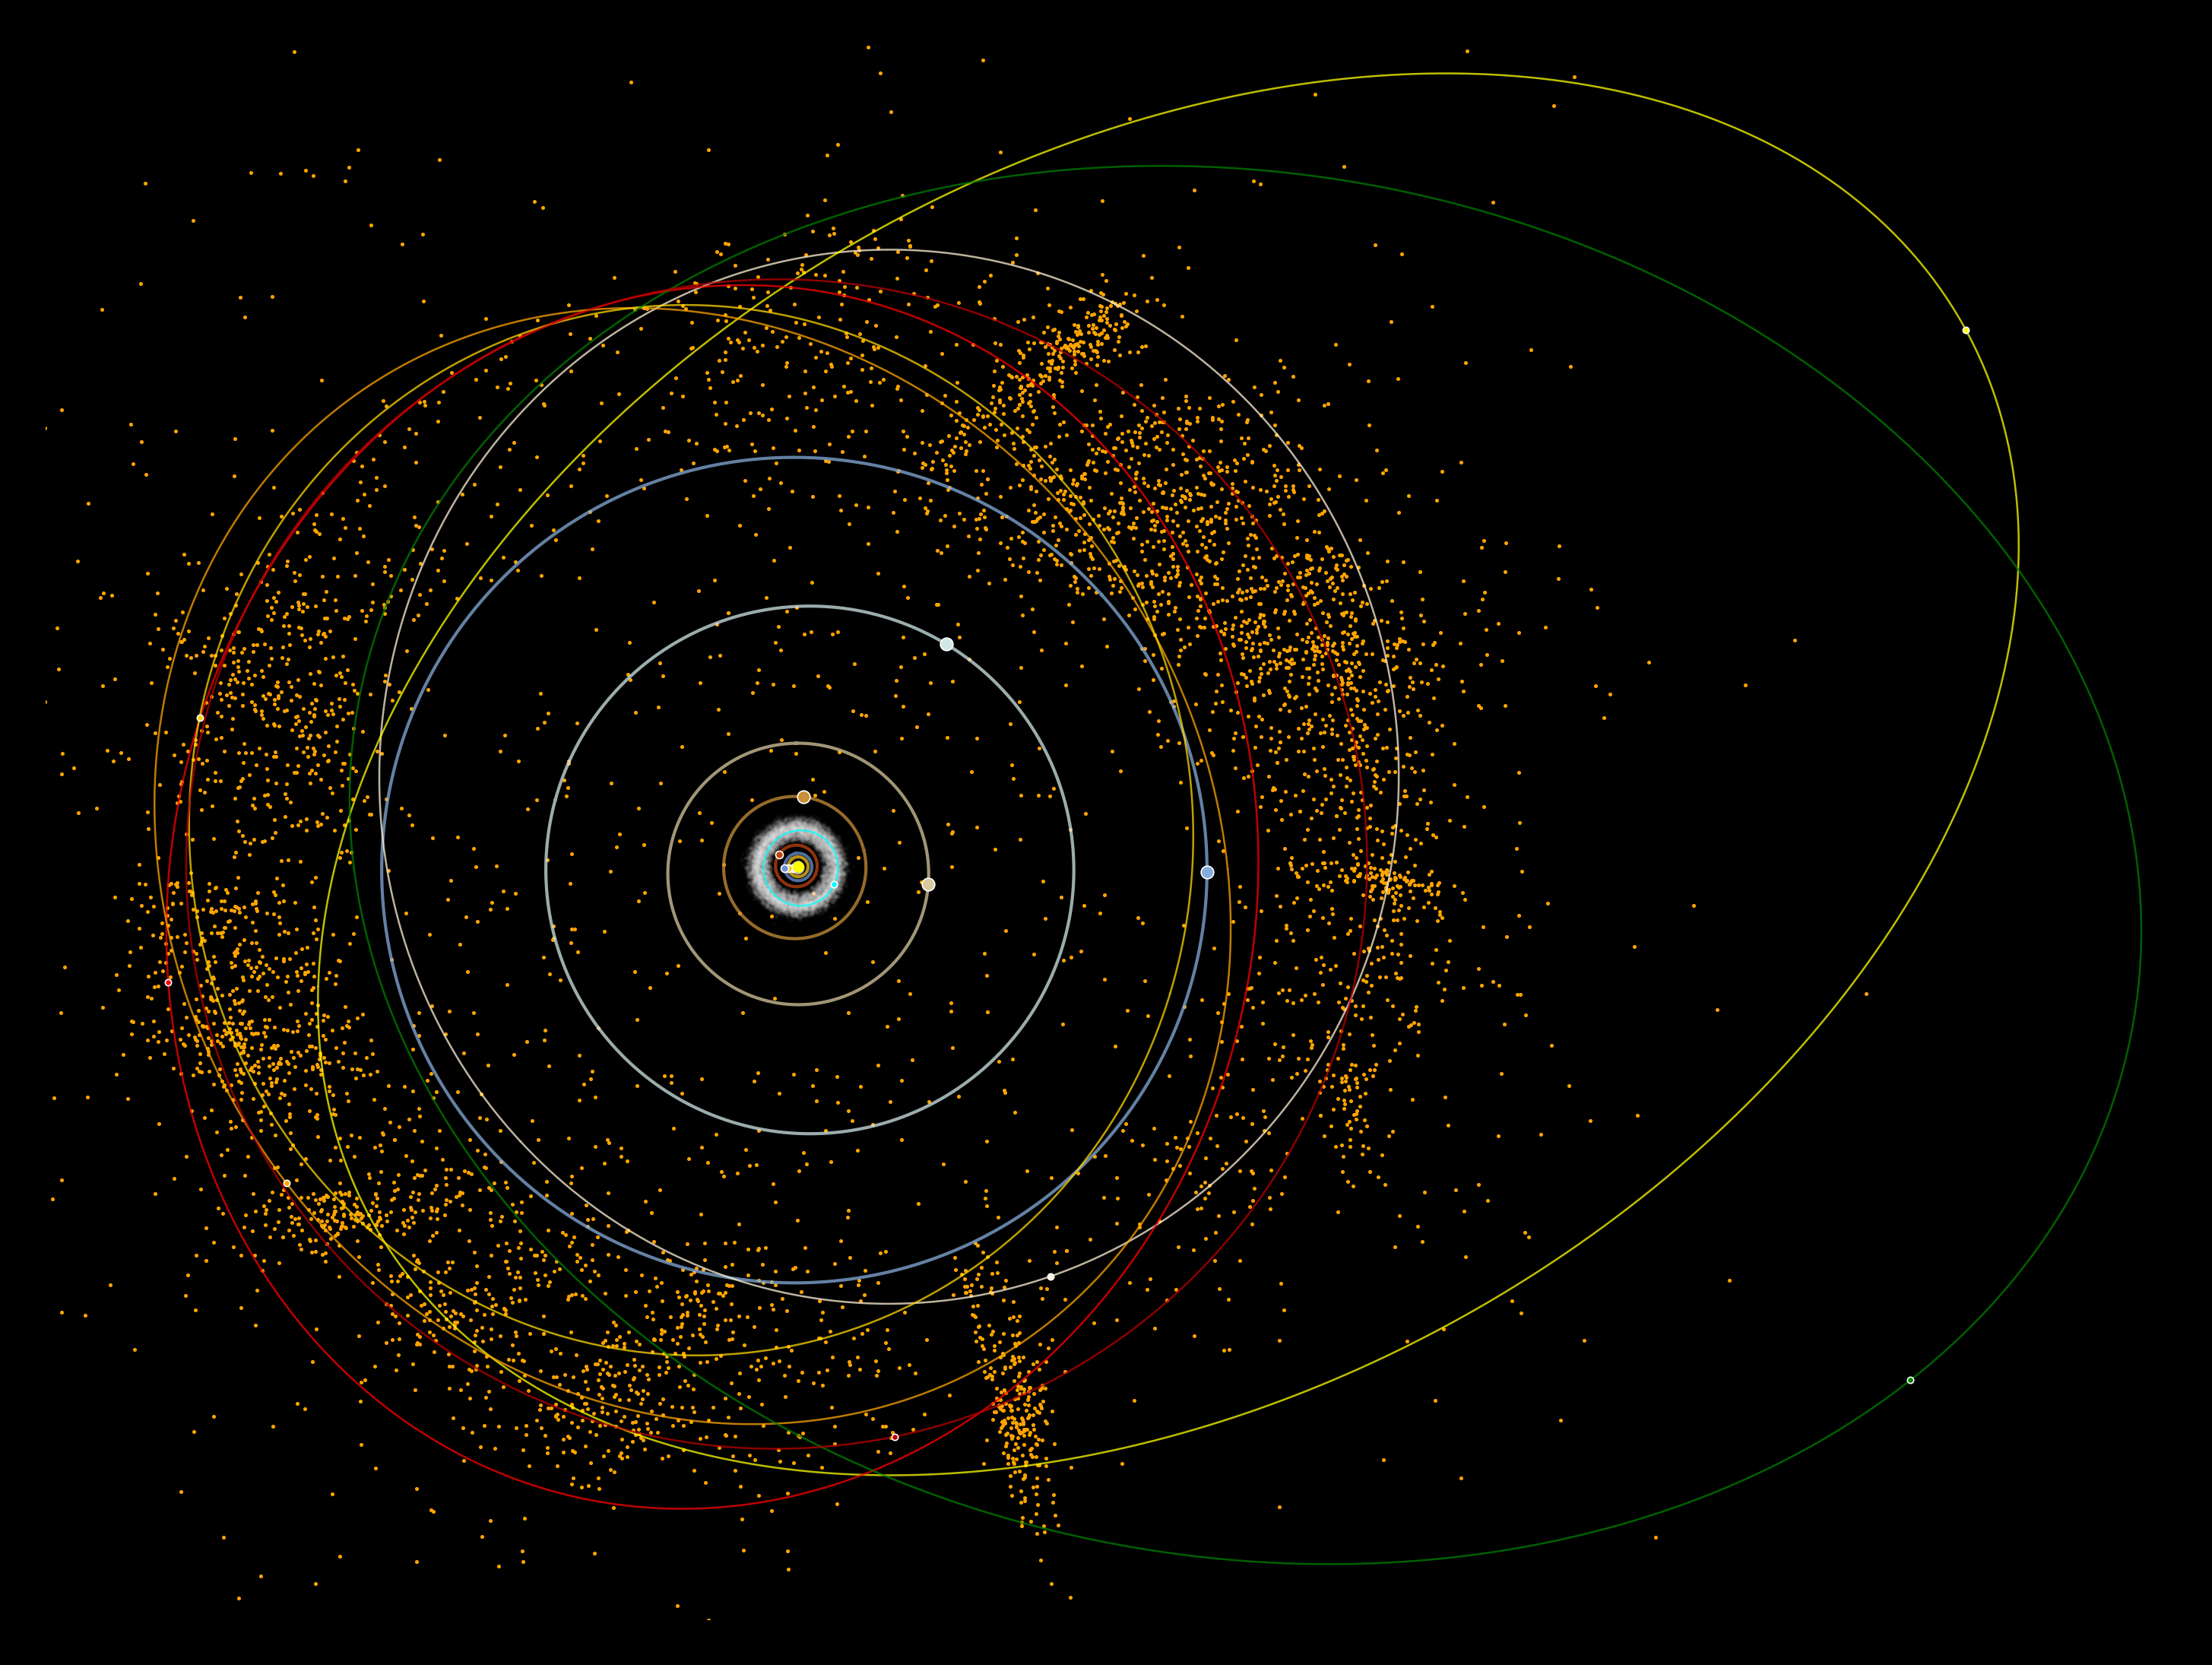

In [74]:
plotFile = f"SolSys_100au_{dateTag}.png"
aMax = 55
axMax = 100
ayMax = 60

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,axMax)
ax.set_xticks([])
ax.set_ylim(-aMax,ayMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# plot the main belt asteroids

ax.plot(xMB,yMB,'o',ms=0.5,mfc='white',mec='white',mew=0.1,alpha=0.03,zorder=8)

# Planet orbits

for body in inner:
    pms = 1.2
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],alpha=0.75,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)

for body in outer:
    pms = 2
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],alpha=0.75,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)
    
# dwarf planets

for body in dwarfs:
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.3,color=colors[body],alpha=0.75,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=1,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)

# plot TNOs and Centaurs

ax.plot(xTNO,yTNO,'o',ms=0.5,mfc='orange',mec='orange',mew=0.1,alpha=1,zorder=7)

# and the sun

ax.plot(0,0,'o',ms=1.5,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()

## Solar System with Halley's Comet

Plot the solar system looking "down" on the XY ecliptic plane beyond the orbit of Neptune, including the 
main belt and TNOs and Centaurs plus Comet 1P/Halley.

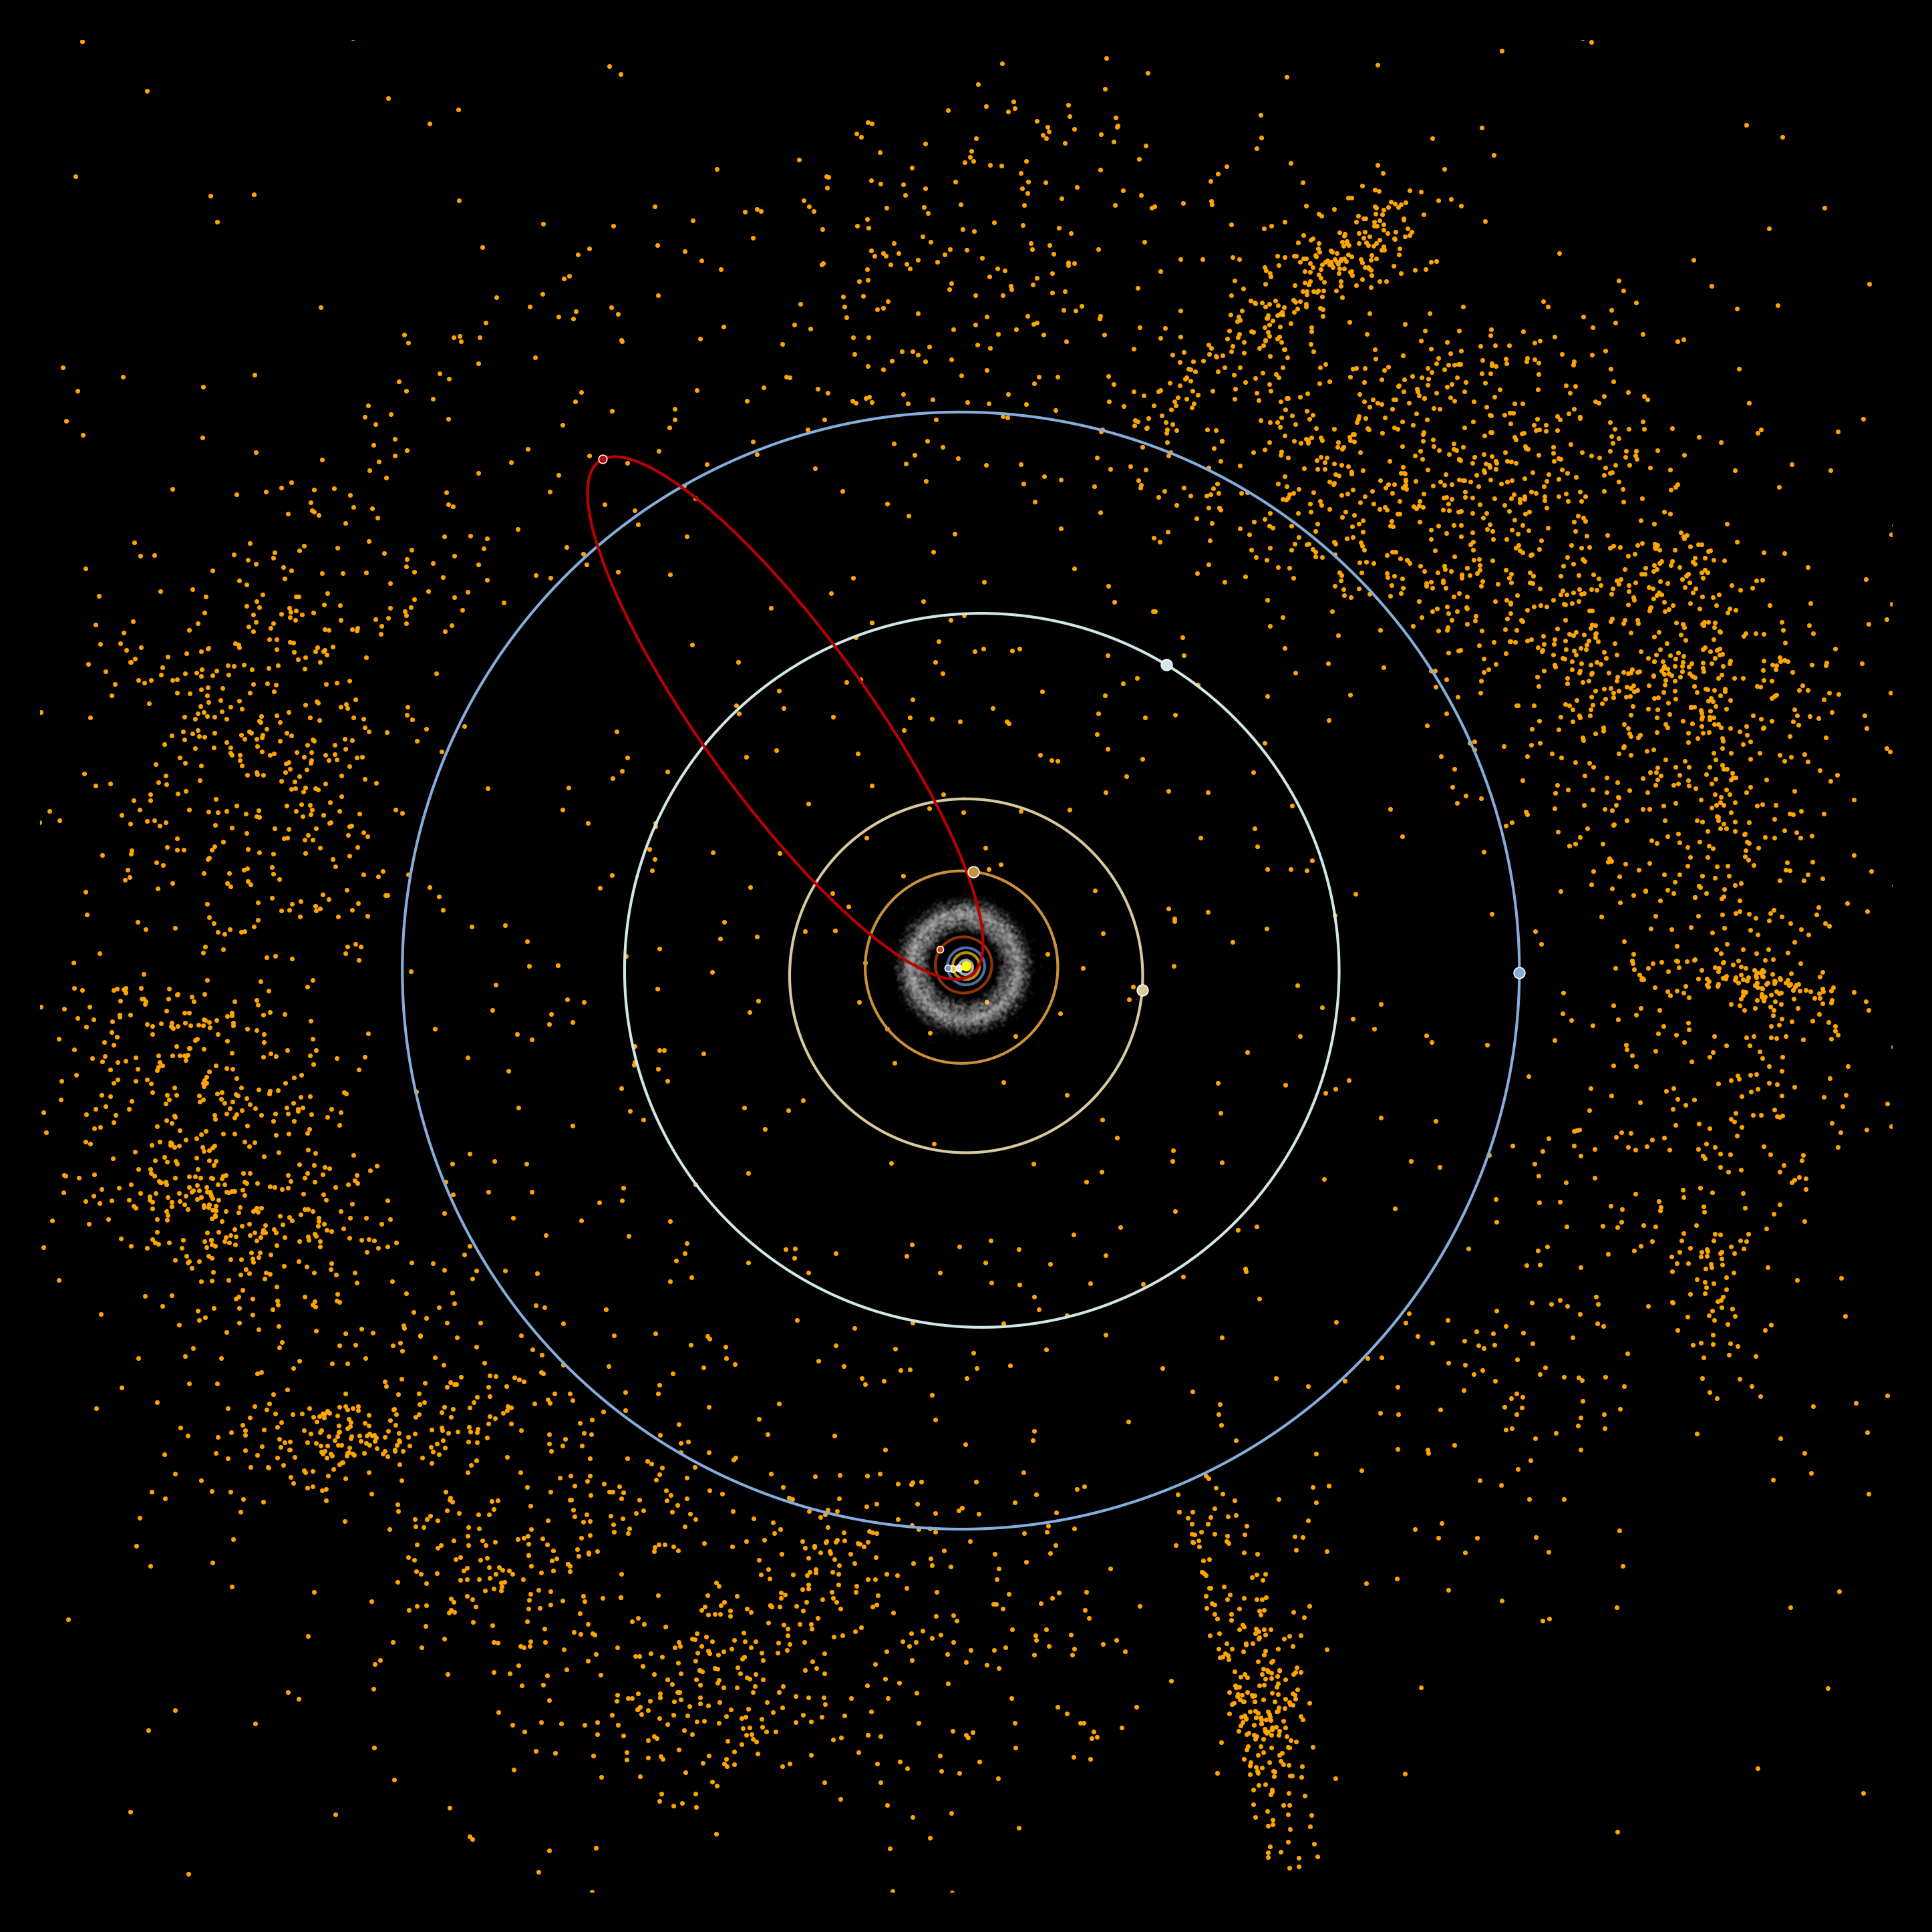

In [75]:
plotFile = f"SolSys_Halley_{dateTag}.png"
aMax = 50

plt.style.use('dark_background')

fig,ax = plt.subplots(figsize=(wInches,hInches),dpi=dpi)
    
ax.tick_params('both',length=6,width=lwidth,which='major',direction='in',top='on',right='on')
ax.tick_params('both',length=3,width=lwidth,which='minor',direction='in',top='on',right='on')

# Limits

ax.set_xlim(-aMax,aMax)
ax.set_xticks([])
ax.set_ylim(-aMax,aMax)
ax.set_yticks([])
ax.set_axis_off()

ax.set_aspect(True)

# plot the main belt asteroids

ax.plot(xMB,yMB,'o',ms=0.5,mfc='white',mec='white',mew=0.1,alpha=0.03,zorder=8)

# Planet orbits

for body in inner:
    pms = 1.2
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],alpha=0.75,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)

for body in outer:
    pms = 2
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],alpha=1,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=pms,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)
    
# dwarf planets

for body in ['1P/Halley']:
    ax.plot(xOrb[body],yOrb[body],'-',lw=0.5,color=colors[body],alpha=1,zorder=9)
    ax.plot(xP[body],yP[body],'o',ms=1.5,mfc=colors[body],mec="white",mew=0.2,alpha=1,zorder=10)

# plot TNOs and Centaurs

ax.plot(xTNO,yTNO,'o',ms=0.75,mfc='orange',mec='orange',mew=0.1,alpha=1,zorder=7)

# and the sun

ax.plot(0,0,'o',ms=1.5,mfc='yellow',mec='yellow',mew=0.3,alpha=1,zorder=10)

# save hardcopy

plt.savefig(plotFile,bbox_inches='tight',facecolor='black')

plt.show()